In this post I'm going to show you my process for solving regression problems with XGBoost in python, using either the native `xgboost` API or the scikit-learn interface.
This is a  powerful methodology that can produce world class results in a short time with minimal thought or effort.
While we'll be working on an old Kagle competition for predicting the sale prices of bulldozers and other heavy machinery, you can use this flow to solve whatever tabular data regression problem you're working on.

This post serves as the explanation and documentation for  the
XGBoost regression jupyter notebook from my 
[ds-templates repo](https://github.com/mcb00/ds-templates)
on GitHub, so go ahead and download the notebook and follow along with your own data.

If you're not already comfortable with the ideas behind gradient boosting and XGBoost, you'll find it helpful to read some of my previous posts to get up to speed.
I'd start with this [introduction to gradient boosting](/posts/gradient-boosting-machine-from-scratch/),
and then read this [explanation of how XGBoost works](/posts/xgboost-explained/).

Let's get into it! 🚀



## Install and import the `xgboost` library

If you don't already have it, go ahead and [use conda to install the xgboost library](https://anaconda.org/conda-forge/xgboost), e.g.

```.zsh
$ conda install -c conda-forge xgboost
```

Then import it along with the usual suspects.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

## Read dataset into python

In this example we'll work on the 
[Kagle Bluebook for Bulldozers](https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview)
competition, which asks us to build a regression model to predict the sale price of heavy equipment.
Amazingly, you can solve your own regression problem by swapping this data out with your organization's data before proceeding with the tutorial.

Go ahead and download the `Train.zip` file from Kagle and extract it into `Train.csv`.
Then read the data into a pandas dataframe.

In [3]:
#| output: false
df = pd.read_csv('Train.csv', parse_dates=['saledate']);

/var/folders/p3/n6r4g5mj3m3dhls3j66tztmh0000gn/T/ipykernel_49280/374828784.py:2: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Train.csv', parse_dates=['saledate']);


Notice I cheated a little bit, checking the columns ahead of time and telling pandas to treat the `saledate` column as a date.
In general it will make life easier to read in any date-like columns as dates.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

## Prepare raw data for XGBoost

When faced with a new tabular dataset for modeling, we have two format considerations: data types and missingness.
From the call to `df.info()` above, we can see we have both mixed types and missing values.

When it comes to missing values, some models like the gradient booster or random forest in scikit-learn require purely non-missing inputs. 
One of the great strengths of XGBoost is that it relaxes this requirement, allowing us to pass in missing feature values, so we don't have to worry about them.

Regarding  data types, all ML models for tabular data require inputs to be numeric, either integers or floats, so we're going to have to deal with those `object` columns.



### Encode string features

The simplest way to encode string variables is to map each unique string value to an integer;
this is called *integer encoding*.

We can easily accomplish this by using the [categorical data type in pandas](https://pandas.pydata.org/docs/user_guide/categorical.html).
The category type is a bit like the factor type in R;
pandas stores the underlying data as integers, and it keeps a mapping from the integers back to the original string values.
XGBoost is able to access the numeric data underlying the categorical features for model training and prediction.
This is a nice way to encode string features because it's easy to implement and it preserves the original category levels in the data frame.
If you prefer to generate your own integer mappings, you can also do it with the scikit-learn
[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [5]:
def encode_string_features(df):
    out_df = df.copy()
    for feature, feature_type in df.dtypes.items():
        if feature_type == 'object':
            out_df[feature] = out_df[feature].astype('category')
    return out_df

df = encode_string_features(df)

### Encode date and timestamp features

While dates feel sort of numeric, they are not numbers, so we need to transform them  into numeric columns.
Unfortunately, encoding timestamps isn't as straightforward as encoding strings, so we actually might need to engage in a little bit of feature engineering.
A single date has many different attributes, e.g. days since epoch, year, quarter, month, day, day of year, day of week, is holiday, etc.
As a starting point, we can just add a few of these attributes as features.
Once a feature is represented as a date or timestamp data type, you can access various attributes via the `dt` attribute.

In [5]:
def encode_datetime_features(df, datetime_features, datetime_attributes):
    out_df = df.copy()
    for datetime_feature in datetime_features:
        for datetime_attribute in datetime_attributes:
            if datetime_attribute == 'days_since_epoch':
                out_df[f'{datetime_feature}_{datetime_attribute}'] = \
                    (out_df[datetime_feature] 
                     - pd.Timestamp(year=1970, month=1, day=1)).dt.days
            else:
                out_df[f'{datetime_feature}_{datetime_attribute}'] = \
                    getattr(out_df[datetime_feature].dt, datetime_attribute)
    return out_df

datetime_features = [
    'saledate',
]
datetime_attributes = [
    'year',
    'month',
    'day',
    'quarter',
    'day_of_year',
    'day_of_week',
    'days_since_epoch',
]

df = encode_datetime_features(df, datetime_features, datetime_attributes)

### Transform the target if necessary

In the interest of speed and efficiency, we didn't bother doing any EDA with the feature data. Part of my justification for this is that trees are incredibly robust to outliers, colinearity, missingness, and other assorted nonsense in the feature data.
However, they are not necessarily robust to nonsense in the target variable, so it's worth having a look at it before proceeding any further.

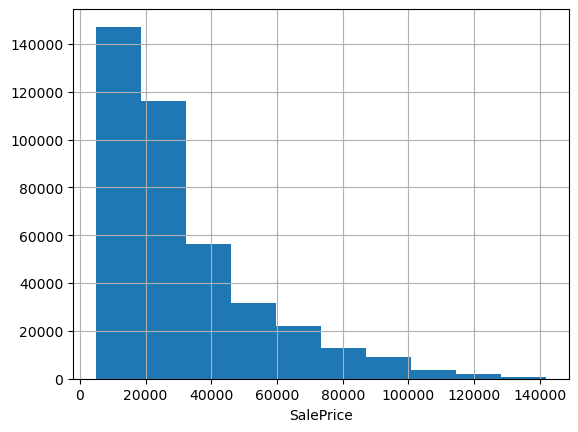

In [6]:
#| fig-alt: histogram of sale price showing right-skewed data
df.SalePrice.hist(); plt.xlabel('SalePrice');

Often when predicting prices it makes sense to use log price, especially when they span multiple orders of magnitude or have a strong right skew.
These data look pretty friendly, lacking outliers and exhibiting only a mild positive skew; we could probably get away without doing any transformation.
But checking the evaluation metric used to score the Kagle competition, we see they're using root mean squared log error.
That's equivalent to using RMSE on log-transformed target data, so let's go ahead and work with log prices.

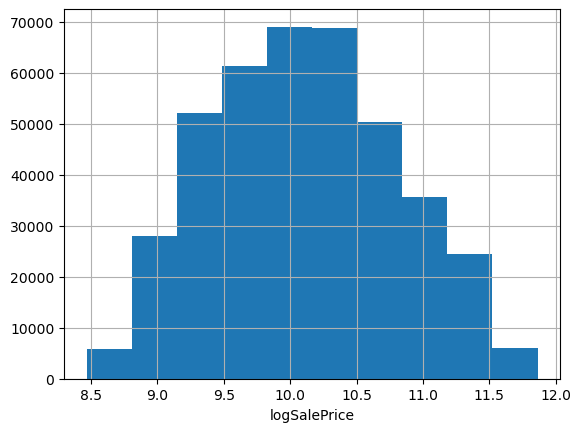

In [7]:
#| fig-alt: histogram of log sale price showing a more symetric distribution
df['logSalePrice'] = np.log1p(df['SalePrice'])
df.logSalePrice.hist(); plt.xlabel('logSalePrice');

### A note on data transformation robustness

Before we jump into training models, let’s talk about how our approach to data transformation  might differ between initial modeling explorations and building robust production-ready ML applications.
When faced with a new modeling problem, our priority is usually to get a prototype model working ASAP. 
Often it’s fastest and easiest to apply transformations to the entire dataset before splitting it into training and validation subsets and commencing model iterations.
That’s the approach we’re taking here.

As we move beyond proof of concept toward a production-ready ML application, we would want to start thinking carefully about robustness in our data transformations.
Considerations might include issues like  how we handle prediction with new values of categorical variables which were not present in training or how to prevent leakage in transformations that compute statistics over the entire dataset.
We can benefit from using tools like scikit-learn’s [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to chain transformations together and prevent leaking information from the training data into the validation data.
We'll save the details of robust data transformation  for another post.

## Train and Evaluate the XGBoost regression model

Having prepared our dataset, we are now ready to train an XGBoost model.
We'll walk through the flow step-by-step first, then later we'll collect the code in a single cell, so it's easier to quickly iterate through variations of the model.

### Specify target and feature columns
First we'll put together a list of our features and define the target column.
I like to have an actual list defined in the code so it's easier to see everything we're puting into the model and easier to add or remove features as we iterate.
Just run something like `list(df.columns)` in a cel to get a copy-pasteable list of columns, then edit it down to the full list of features, i.e. remove the target, date columns, and other non-feature columns..

In [8]:
# list(df.columns)

In [9]:
features = [
    'SalesID',
    'MachineID',
    'ModelID',
    'datasource',
    'auctioneerID',
    'YearMade',
    'MachineHoursCurrentMeter',
    'UsageBand',
    'fiModelDesc',
    'fiBaseModel',
    'fiSecondaryDesc',
    'fiModelSeries',
    'fiModelDescriptor',
    'ProductSize',
    'fiProductClassDesc',
    'state',
    'ProductGroup',
    'ProductGroupDesc',
    'Drive_System',
    'Enclosure',
    'Forks',
    'Pad_Type',
    'Ride_Control',
    'Stick',
    'Transmission',
    'Turbocharged',
    'Blade_Extension',
    'Blade_Width',
    'Enclosure_Type',
    'Engine_Horsepower',
    'Hydraulics',
    'Pushblock',
    'Ripper',
    'Scarifier',
    'Tip_Control',
    'Tire_Size',
    'Coupler',
    'Coupler_System',
    'Grouser_Tracks',
    'Hydraulics_Flow',
    'Track_Type',
    'Undercarriage_Pad_Width',
    'Stick_Length',
    'Thumb',
    'Pattern_Changer',
    'Grouser_Type',
    'Backhoe_Mounting',
    'Blade_Type',
    'Travel_Controls',
    'Differential_Type',
    'Steering_Controls',
    'saledate_year',
    'saledate_month',
    'saledate_day',
    'saledate_quarter',
    'saledate_day_of_year',
    'saledate_day_of_week',
    'saledate_days_since_epoch'
]

target = 'logSalePrice'

### Split the data into training and validation sets

Next we split the dataset into a training set and a validation set.
Of course since we're going to evaluate against the validation set a number of times as we iterate, it's best practice to keep a separate test set reserved to check our final model to ensure it generalizes well.
Assuming that final test set is hidden away, we can use the rest of the data for training and validation.

There are two main ways we might want to select the validation set.
If there isn't a temporal ordering of the observations, we might be able to randomly sample.
In practice, it's much more common that observations have a temporal ordering, and that models are trained on observations up to a certain time and used to predict on observations occuring after that time.
Since this data is temporal, we don't want to split randomly; instead we'll split on observation date, reserving the latest observations for the validation set.

In [10]:
# Temporal Validation Set
def train_test_split_temporal(df, datetime_column, n_test):
    idx_sort = np.argsort(df[datetime_column])
    idx_train, idx_test = idx_sort[:-n_valid], idx_sort[-n_valid:]
    return df.iloc[idx_train, :], df.iloc[idx_test, :]


# Random Validation Set
def train_test_split_random(df, n_test):
    np.random.seed(42)
    idx_sort = np.random.permutation(len(df))
    idx_train, idx_test = idx_sort[:-n_valid], idx_sort[-n_valid:]
    return df.iloc[idx_train, :], df.iloc[idx_test, :]

my_train_test_split = lambda d, n_valid: train_test_split_temporal(d, 'saledate', n_valid)
# my_train_test_split = lambda d, n_valid: train_test_split_random(d, n_valid)

In [11]:
n_valid = 12000
train_df, valid_df = my_train_test_split(df, n_valid)

train_df.shape, valid_df.shape

((389125, 61), (12000, 61))

### Create `DMatrix` data objects

XGBoost uses a data type called dense matrix for efficient training and prediction, so next we need to create `DMatrix` objects for our training and validation datasets.

> If you prefer to use the scikit-learn interface to XGBoost, you don't need to create these dense matrix objects. More on that below.

In [12]:
dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], enable_categorical=True)

### Set the XGBoost parameters

XGBoost has [numerous hyperparameters](https://xgboost.readthedocs.io/en/latest/parameter.html).
Fortunately, just a handful of them tend to be the most influential; furthermore, the default values are not bad in most situations.
I like to start out with a dictionary containing the default parameter values for just the ones I think are most important.
For training there is one required boosting parameter called `num_boost_round` which I set to 50 as a starting point; you can make this smaller initially if training takes too long.

In [13]:
# default values for important parameters
params = {
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}
num_boost_round = 50

### Train the XGBoost model

Check out the [documentation on the learning API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
to see all the training options.
During training, I like to have XGBoost print out the evaluation metric on the train and validation set after every few boosting rounds and again at the end of training; that can be done by setting `evals` and `verbose_eval`.
You can also save the evaluation results in a dictionary passed into `evals_result` to inspect and plot the objective curve over the training iterations.

In [14]:
evals_result = {}
m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')],
              verbose_eval=10,
              evals_result=evals_result)

[0]	train-rmse:6.74422	valid-rmse:6.79733
[10]	train-rmse:0.34798	valid-rmse:0.37158
[20]	train-rmse:0.26289	valid-rmse:0.28239
[30]	train-rmse:0.25148	valid-rmse:0.27028
[40]	train-rmse:0.24375	valid-rmse:0.26420
[49]	train-rmse:0.23738	valid-rmse:0.25855


### Train the XGBoost model using the sklearn interface

You can optionally use the [sklearn estimator interface](https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html)
to XGBoost.
This will bypass the need to use the `DMatrix` data objects for training and prediction, and it will allow you to leverage many of the other scikit-learn ecosystem tools like pipelines, parameter search, partial dependence plots, etc.
The `XGBRegressor` is available in the `xgboost` library that we've already imported.

In [15]:
# scikit-learn interface
reg = xgb.XGBRegressor(n_estimators=num_boost_round, **params)
reg.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-rmse:6.74422	validation_1-rmse:6.79733
[10]	validation_0-rmse:0.34798	validation_1-rmse:0.37158
[20]	validation_0-rmse:0.26289	validation_1-rmse:0.28239
[30]	validation_0-rmse:0.25148	validation_1-rmse:0.27028
[40]	validation_0-rmse:0.24375	validation_1-rmse:0.26420
[49]	validation_0-rmse:0.23738	validation_1-rmse:0.25855


Since not all features of XGBoost are available through the scikit-learn estimator interface, you might want to get the native booster object back out of the sklearn wrapper.

In [16]:
m = reg.get_booster()

### Evaluate the model and check for overfitting

We get the model evaluation metrics on the training and validation sets printed to stdout when we use the `evals` argument to the training API. 
Typically I just look at those printed metrics, but let's double check by hand.

In [17]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

root_mean_squared_error(dvalid.get_label(), m.predict(dvalid))

0.25855368

So, how good is that RMSLE of 0.259?
Well, checking the 
[Kagle leaderboard](https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard) 
for this competition, we would have come in 53rd out of 474, which is in the top 12% of submissions.
That's not bad for 10 minutes of work doing the bare minimum necessary to transform the raw data into a format consumable by XGBoost and then training a model using default hyperparameter values.

> Note that we're using a different validation set from that used for the final leaderboard (which is long closed), but our score is likely still a decent approximation for how we would have done in the competition.

It can be helpful to take a look at objective curves for training and validation data to get a sense for the extent of overfitting.
A huge difference between training and validation performance indicates overfitting.
In the below curve, there is very little overfitting, indicating we can be aggressive with hyperparameters that increase model flexibility.
More on that soon.

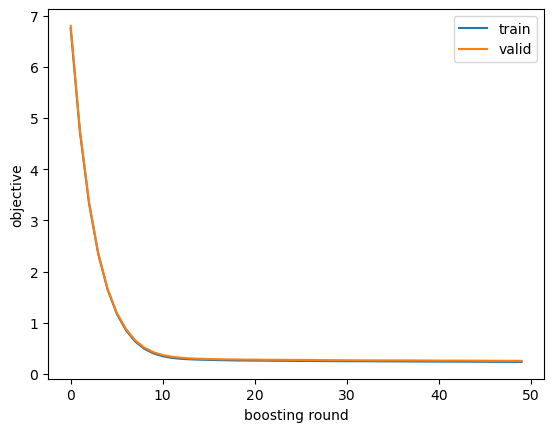

In [18]:
#| fig-alt: line plot showing objective function versus training iteration for training and validation sets
pd.DataFrame({
    'train': evals_result['train']['rmse'],
    'valid': evals_result['valid']['rmse']
}).plot(); plt.xlabel('boosting round'); plt.ylabel('objective');

### Check feature importance

It's helpful to get an idea of how much the model is using each feature.
In following iterations we might want to try dropping low-signal features or examining the important ones more closely for feature engineering ideas.
The gigantic caveat to keep in mind here is that there are different measures of feature importance, and each one will give different importances.
XGBoost provides three importance measures; I tend to prefer looking at the weight measure because its rankings usually seem most intuitive.

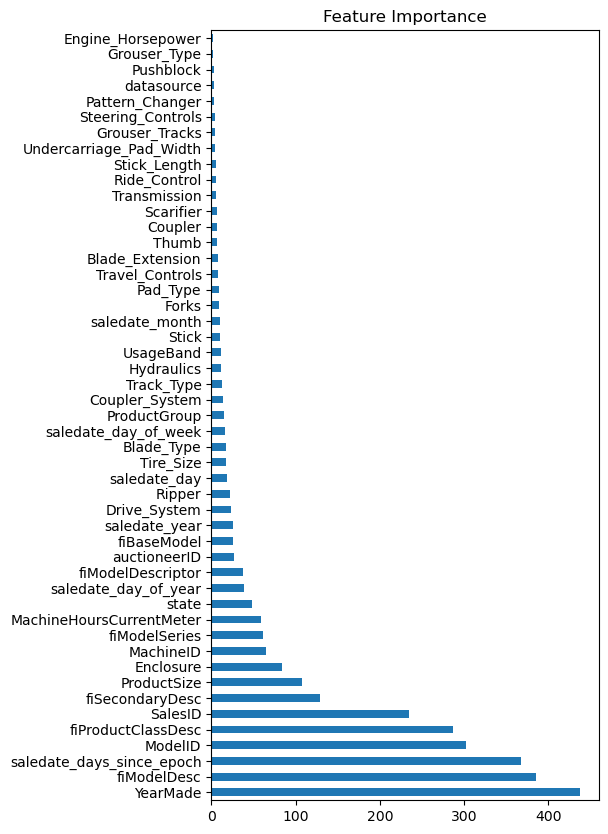

In [19]:
#| fig-alt: feature importance plot showing a few high importance features and many low importance ones
fig, ax = plt.subplots(figsize=(5,10))
feature_importances = pd.Series(m.get_score(importance_type='weight')).sort_values(ascending=False)
feature_importances.plot.barh(ax=ax)
plt.title('Feature Importance');

## Improve performance using a model iteration loop

At this point we have a half-decent prototype model. Now we enter the model iteration loop in which we adjust features and model parameters to find configurations that have better and better performance.  

Let's start by putting the feature and target specification, the training/validation split, the model training, and the evaluation all together in one code block that we can copy paste for easy model iteration.

> Note that for this process to be effective, model training needs to take less than 10 seconds. Otherwise you'll be sitting around waiting way too long.
If training takes too long, try training on a sample of the training data, or try reducing the number of boosting rounds.

In [20]:
features = [
    'SalesID',
    'MachineID',
    'ModelID',
    'datasource',
    'auctioneerID',
    'YearMade',
    'MachineHoursCurrentMeter',
    'UsageBand',
    'fiModelDesc',
    'fiBaseModel',
    'fiSecondaryDesc',
    'fiModelSeries',
    'fiModelDescriptor',
    'ProductSize',
    'fiProductClassDesc',
    'state',
    'ProductGroup',
    'ProductGroupDesc',
    'Drive_System',
    'Enclosure',
    'Forks',
    'Pad_Type',
    'Ride_Control',
    'Stick',
    'Transmission',
    'Turbocharged',
    'Blade_Extension',
    'Blade_Width',
    'Enclosure_Type',
    'Engine_Horsepower',
    'Hydraulics',
    'Pushblock',
    'Ripper',
    'Scarifier',
    'Tip_Control',
    'Tire_Size',
    'Coupler',
    'Coupler_System',
    'Grouser_Tracks',
    'Hydraulics_Flow',
    'Track_Type',
    'Undercarriage_Pad_Width',
    'Stick_Length',
    'Thumb',
    'Pattern_Changer',
    'Grouser_Type',
    'Backhoe_Mounting',
    'Blade_Type',
    'Travel_Controls',
    'Differential_Type',
    'Steering_Controls',
    'saledate_year',
    'saledate_month',
    'saledate_day',
    'saledate_quarter',
    'saledate_day_of_year',
    'saledate_day_of_week',
    'saledate_days_since_epoch',
]

target = 'logSalePrice'

train_df, valid_df = train_test_split_temporal(df, 'saledate', 12000)
dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], enable_categorical=True)

params = {
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}
num_boost_round = 50

m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')],verbose_eval=10)

[0]	train-rmse:6.74422	valid-rmse:6.79733
[10]	train-rmse:0.34798	valid-rmse:0.37158
[20]	train-rmse:0.26289	valid-rmse:0.28239
[30]	train-rmse:0.25148	valid-rmse:0.27028
[40]	train-rmse:0.24375	valid-rmse:0.26420
[49]	train-rmse:0.23738	valid-rmse:0.25855


### Feature selection

#### Drop low-importance features

Let's try training a model on only the top k most important features.
You can try different values of k for the rankings created from each of the three importance measures.
You can play with how many to keep, looking for the optimal number manually.


In [21]:
feature_importances_weight = pd.Series(m.get_score(importance_type='weight')).sort_values(ascending=False)
feature_importances_cover = pd.Series(m.get_score(importance_type='cover')).sort_values(ascending=False)
feature_importances_gain = pd.Series(m.get_score(importance_type='gain')).sort_values(ascending=False)

In [22]:
# features = list(feature_importances_weight[:30].index)
# features = list(feature_importances_cover[:35].index)
features = list(feature_importances_gain[:30].index)

dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], enable_categorical=True)

params = {
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}
num_boost_round = 50

m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')], verbose_eval=10)

[0]	train-rmse:6.74422	valid-rmse:6.79733
[10]	train-rmse:0.34798	valid-rmse:0.37150
[20]	train-rmse:0.26182	valid-rmse:0.27986
[30]	train-rmse:0.24974	valid-rmse:0.26896
[40]	train-rmse:0.24282	valid-rmse:0.26043
[49]	train-rmse:0.23768	valid-rmse:0.25664


Looks like keeping the top 30 from the gain importance type gives a slight performance improvement.

#### Drop one feature at a time

Next  try dropping each feature out of the model one-at-a-time to see if there are any more features that you can drop.
For each feature, drop it from the feature set, then train a new model, then record the evaluation score.
At the end,  sort the scores to see which features are the best candidates for removal.

In [23]:
features = [
    'Coupler_System',
     'Tire_Size',
     'Scarifier',
     'ProductSize',
     'Ride_Control',
     'fiBaseModel',
     'Enclosure',
     'Pad_Type',
     'YearMade',
     'fiSecondaryDesc',
     'ProductGroup',
     'Drive_System',
     'Ripper',
     'saledate_days_since_epoch',
     'fiModelDescriptor',
     'fiProductClassDesc',
     'MachineID',
     'Hydraulics',
     'SalesID',
     'Track_Type',
     'ModelID',
     'fiModelDesc',
     'Travel_Controls',
     'Transmission',
     'Blade_Extension',
     'fiModelSeries',
     'Grouser_Tracks',
     'Undercarriage_Pad_Width',
     'Stick',
     'Thumb'
]

# drop each feature one-at-a-time
scores = []
for i, feature in enumerate(features):
    drop_one_features = features[:i] + features[i+1:]

    dtrain = xgb.DMatrix(data=train_df[drop_one_features], label=train_df[target], enable_categorical=True)
    dvalid = xgb.DMatrix(data=valid_df[drop_one_features], label=valid_df[target], enable_categorical=True)

    params = {
        'learning_rate': 0.3,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 1,
        'colsample_bynode': 1,
        'objective': 'reg:squarederror',
    }
    num_boost_round = 50

    m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                evals=[(dtrain, 'train'), (dvalid, 'valid')],
                verbose_eval=False)
    score = root_mean_squared_error(dvalid.get_label(), m.predict(dvalid))
    scores.append(score)

results_df = pd.DataFrame({
    'feature': features,
    'score': scores
})
results_df.sort_values(by='score')

,feature,score
18,SalesID,0.252617
5,fiBaseModel,0.253710
27,Undercarriage_Pad_Width,0.254032
17,Hydraulics,0.254114
20,ModelID,0.254169
4,Ride_Control,0.254278
16,MachineID,0.254413
19,Track_Type,0.254825
6,Enclosure,0.254958
28,Stick,0.255164


Next try removing the feature with the best removal score.
Then with that feature still removed, also try removing the feature with the next best removal score and so on.
Repeat this process until the model evaluation metric is no longer improving.
I think this could be considered a faster version of backward stepwise feature selection.


In [24]:
features = [
    'Coupler_System',
     'Tire_Size',
     'Scarifier',
     'ProductSize',
     'Ride_Control',
#      'fiBaseModel',
     'Enclosure',
     'Pad_Type',
     'YearMade',
     'fiSecondaryDesc',
     'ProductGroup',
     'Drive_System',
     'Ripper',
     'saledate_days_since_epoch',
     'fiModelDescriptor',
     'fiProductClassDesc',
     'MachineID',
#      'Hydraulics',
#      'SalesID',
     'Track_Type',
     'ModelID',
     'fiModelDesc',
     'Travel_Controls',
     'Transmission',
     'Blade_Extension',
     'fiModelSeries',
     'Grouser_Tracks',
#      'Undercarriage_Pad_Width',
     'Stick',
     'Thumb'
]

dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], enable_categorical=True)

params = {
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}
num_boost_round = 50

m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')], verbose_eval=10)

[0]	train-rmse:6.74422	valid-rmse:6.79145
[10]	train-rmse:0.34882	valid-rmse:0.37201
[20]	train-rmse:0.26050	valid-rmse:0.27386
[30]	train-rmse:0.24844	valid-rmse:0.26205
[40]	train-rmse:0.24042	valid-rmse:0.25426
[49]	train-rmse:0.23549	valid-rmse:0.25004


So here I was able to remove four more features before the score started getting worse.
With our reduced feature set, we're now ranking 39th on that Kagle leaderboard.
Let's see how far we can get with some hyperparameter tuning.

### Tune the XGBoost hyperparameters

This is a topic which deserves its own full-length post, but just for fun, here I'll do a quick and dirty hand tuning without a ton of explanation.

Broadly speaking, my process is to increase model expressiveness by increasing the maximum tree depth untill it looks like I'm overfitting.
At that point, I start pushing tree pruning parameters like min child weight and regularization parameters like lambda to counteract the overfitting.
That process lead me to the following parameters.

In [25]:
params = {
    'learning_rate': 0.3,
    'max_depth': 10,
    'min_child_weight': 14,
    'lambda': 5,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',}
num_boost_round = 50

m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')], verbose_eval=10)

[0]	train-rmse:6.74473	valid-rmse:6.80196
[10]	train-rmse:0.31833	valid-rmse:0.34151
[20]	train-rmse:0.22651	valid-rmse:0.24885
[30]	train-rmse:0.21501	valid-rmse:0.23904
[40]	train-rmse:0.20897	valid-rmse:0.23645
[49]	train-rmse:0.20418	valid-rmse:0.23412


That gets us up to 12th place.
Next I start reducing the learning rate and increasing the boosting rounds in proportion to one another.

In [26]:
params = {
    'learning_rate': 0.3/5,
    'max_depth': 10,
    'min_child_weight': 14,
    'lambda': 5,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',}
num_boost_round = 50*5

m = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')], verbose_eval=10)

[0]	train-rmse:9.04930	valid-rmse:9.12743
[10]	train-rmse:4.88505	valid-rmse:4.93769
[20]	train-rmse:2.64630	valid-rmse:2.68501
[30]	train-rmse:1.44703	valid-rmse:1.47923
[40]	train-rmse:0.81123	valid-rmse:0.84079
[50]	train-rmse:0.48441	valid-rmse:0.51272
[60]	train-rmse:0.32887	valid-rmse:0.35434
[70]	train-rmse:0.26276	valid-rmse:0.28630
[80]	train-rmse:0.23720	valid-rmse:0.26026
[90]	train-rmse:0.22658	valid-rmse:0.24932
[100]	train-rmse:0.22119	valid-rmse:0.24441
[110]	train-rmse:0.21747	valid-rmse:0.24114
[120]	train-rmse:0.21479	valid-rmse:0.23923
[130]	train-rmse:0.21250	valid-rmse:0.23768
[140]	train-rmse:0.21099	valid-rmse:0.23618
[150]	train-rmse:0.20928	valid-rmse:0.23524
[160]	train-rmse:0.20767	valid-rmse:0.23445
[170]	train-rmse:0.20658	valid-rmse:0.23375
[180]	train-rmse:0.20558	valid-rmse:0.23307
[190]	train-rmse:0.20431	valid-rmse:0.23252
[200]	train-rmse:0.20316	valid-rmse:0.23181
[210]	train-rmse:0.20226	valid-rmse:0.23145
[220]	train-rmse:0.20133	valid-rmse:0.23087

Decreasing the learning rate and increasing the boosting rounds got us up to a 2nd place score.
Notice that the score is still decreasing on the validation set.
We can actually continue boosting on this model by passing it to the `xgb_model` argument in the `train` function.
We want to go very very slowly here to avoid overshooting the minimum of the objective function.
To do that I ramp up the lambda regularization parameter and boost a few more rounds from where we left off.

In [27]:
# second stage
params = {
    'learning_rate': 0.3/10,
    'max_depth': 10,
    'min_child_weight': 14,
    'lambda': 60,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',}
num_boost_round = 50*3

m1 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
              evals=[(dtrain, 'train'), (dvalid, 'valid')], verbose_eval=10,
              xgb_model=m)

[0]	train-rmse:0.19900	valid-rmse:0.23007
[10]	train-rmse:0.19862	valid-rmse:0.22990
[20]	train-rmse:0.19831	valid-rmse:0.22975
[30]	train-rmse:0.19796	valid-rmse:0.22964
[40]	train-rmse:0.19768	valid-rmse:0.22955
[50]	train-rmse:0.19739	valid-rmse:0.22940
[60]	train-rmse:0.19714	valid-rmse:0.22935
[70]	train-rmse:0.19689	valid-rmse:0.22927
[80]	train-rmse:0.19664	valid-rmse:0.22915
[90]	train-rmse:0.19646	valid-rmse:0.22915
[100]	train-rmse:0.19620	valid-rmse:0.22910
[110]	train-rmse:0.19604	valid-rmse:0.22907
[120]	train-rmse:0.19583	valid-rmse:0.22901
[130]	train-rmse:0.19562	valid-rmse:0.22899
[140]	train-rmse:0.19546	valid-rmse:0.22898
[149]	train-rmse:0.19520	valid-rmse:0.22886


In [28]:
root_mean_squared_error(dvalid.get_label(), m1.predict(dvalid))

0.22885828

And that gets us to 1st place on the leaderboard.

## Wrapping Up

There you have it, how to use XGBoost to solve a regression problem in python with world class performance.
Remember you can use the XGBoost regression notebook from my [ds-templates repo](https://github.com/mcb00/ds-templates) 
to make it easy to follow this flow on your own problems.
If you found this helpful, or if you have additional ideas about solving regression problems with XGBoost, let me know down in the comments.